# Fine tuning an image classifier

Given a photo library and a set of photos, can we find similar ones?
For example if we want to find some pictures of artwork, can we find them all given a sample of a few images?

Method:

* Create a sample dataset
* Use a pretrained image classifier from Torchvision
* Fine tune the model on part of the sample dataset
* Predict all the images from the dataset and find matching images


Models to test:

* PCA + logistic regression
* CNN
* EfficientNet
* EfficientNet + Transfer learning
* Data augmentation (?)


Reference:

* https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

## Load images

Filter to only two classes from CIFAR.
We will also limit the dataset size to make learning here hard.

The CIFAR dataset is loaded as PIL objects. We transform the PIL images from CIFAR10 to Tensors (`ToTensor()`), which changes their range from 0-255 to 0-1. We normalise images to a similar distribution as ImageNet images. This will help with transfer learning ImageNet based model. The model was trained on ImageNet images and if we send in images with a different distribution we would expect lower performance.

The normalisation function is a shift `image = (image - mean) / std`. As such we changes our distribution with mean: `[0.4970, 0.4942, 0.4907]` -> `[0.0526, 0.1706, 0.3764]`
and std: `[0.2633, 0.2602, 0.2790]` -> `[1.1497, 1.1616, 1.2400]`

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(0)

image_net_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


def load_cifar_sample(classes, n_images):
    # Define the transformations to apply to the images
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            image_net_normalize,
        ]
    )

    trainset = torchvision.datasets.CIFAR10(
        root="./data/cifar-10/", train=True, download=True, transform=transform
    )
    testset = torchvision.datasets.CIFAR10(
        root="./data/cifar-10/", train=False, download=True, transform=transform
    )

    # Filter the datasets to select only the specified classes
    train_indices = [
        i
        for i, label in enumerate(trainset.targets)
        if trainset.classes[label] in classes
    ]
    test_indices = [
        i
        for i, label in enumerate(testset.targets)
        if testset.classes[label] in classes
    ]
    train_dataset = torch.utils.data.Subset(trainset, train_indices[:n_images])
    test_dataset = torch.utils.data.Subset(testset, test_indices[:n_images])

    # Create data loaders to load the data in full batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=n_images, shuffle=False
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=n_images, shuffle=False
    )

    return train_loader, test_loader


# Define the classes to select
classes = ["airplane", "automobile"]
n_images = 100
train_loader, test_loader = load_cifar_sample(classes, n_images)
class_lookup = {
    val: key for key, val in train_loader.dataset.dataset.class_to_idx.items()
}


Files already downloaded and verified
Files already downloaded and verified


Load the dataset into memory to speed up subsequent training. This is do-able as our dataset is small.

Preview a few items

The images look distorted as we've transformed them towards 0 mean. Matplotlib is expecting images on the scale 0-255.

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1082104108.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1082104108.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


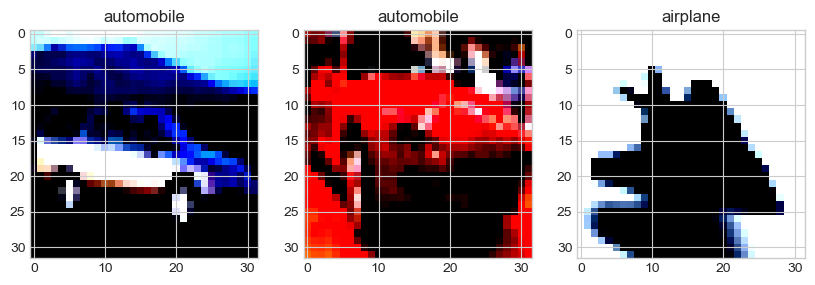

In [3]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")


def get_np_image_from_batch(img_batch, idx):
    img = img_batch.cpu().numpy()[idx]
    # convert image back to Height,Width,Channels
    img = np.transpose(img, (1, 2, 0))
    return img


# get first batch
img_batch, labels_batch = next(iter(train_loader))

n_images_plot = 3
fig, ax = plt.subplots(figsize=(10, 6), ncols=n_images_plot)
for _idx in range(n_images_plot):
    ax[_idx].imshow(get_np_image_from_batch(img_batch, _idx))
    ax[_idx].set_title(class_lookup[int(labels_batch[_idx])])
fig.show()


In [4]:
# print("raw dataset values")
# trainset = train_loader.dataset.dataset.data
# print("Min value: ", np.min(trainset))
# print("Max value: ", np.max(trainset))
# print("Channel means: ", trainset.transpose([3, 0, 1, 2]).reshape(3, -1).mean(axis=1))
# print("")

print("tensor transformed summary values")
print("Min value: ", img_batch.min())
print("Max value: ", img_batch.max())
print("Channel means: ", img_batch.mean(dim=[0, 2, 3]))


tensor transformed summary values
Min value:  tensor(-2.1179)
Max value:  tensor(2.6400)
Channel means:  tensor([0.0526, 0.1706, 0.3764])


## Build models

In [5]:
import timeit

model_outputs = {}
model_times = {}


def timer_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = timeit.default_timer()
        result = func(*args, **kwargs)
        end_time = timeit.default_timer()
        execution_time = end_time - start_time
        print(f"Execution time of {func.__name__}: {execution_time} seconds")
        return result

    return wrapper


### Sci-kit Learn Logistic regression baseline

Load all batches and concat to single matrix.
We concat the three colour dimensions to a single vector of `32*32*3=3072` features.
We will use PCA as a means to control for overfitting.

In [6]:
# Torch tensors to numpy
all_images_train, all_targets_train = next(iter(train_loader))
all_images_test, all_targets_test = next(iter(test_loader))

X_train = all_images_train.numpy().reshape(n_images, -1)
y_train = all_targets_train.numpy()
X_test = all_images_test.numpy().reshape(n_images, -1)
y_test = all_targets_test.numpy()


Train our model and predict targets

In [7]:
import sklearn.pipeline
import sklearn.decomposition
import sklearn.linear_model

linear_model = sklearn.pipeline.make_pipeline(
    sklearn.decomposition.PCA(n_components=20),
    sklearn.linear_model.LogisticRegression(),
)
start_time = timeit.default_timer()
linear_model.fit(X_train, y_train)
model_times["sk_logistic_reg"] = timeit.default_timer() - start_time

y_train_est = linear_model.predict_proba(X_train)
y_test_est = linear_model.predict_proba(X_test)

model_outputs["sk_logistic_reg"] = [y_train_est, y_test_est]


Metrics

We have a class split of 50/50, so accuracy above this means we are learning.

In [8]:
import sklearn.metrics
import pandas as pd


def evaluate_predictions(y_train, y_train_est, y_test, y_test_est) -> dict:
    return {
        "log_loss_train": sklearn.metrics.log_loss(y_train, y_train_est),
        "log_loss_test": sklearn.metrics.log_loss(y_test, y_test_est),
        "accuracy_score_train": sklearn.metrics.accuracy_score(
            y_train, y_train_est[:, 1] > y_train_est[:, 0]
        ),
        "accuracy_score_test": sklearn.metrics.accuracy_score(
            y_test, y_test_est[:, 1] > y_test_est[:, 0]
        ),
    }


def evaluate_all_models(model_outputs: dict) -> pd.DataFrame:
    results = []
    for name, model_output in model_outputs.items():
        _results = evaluate_predictions(
            y_train, model_output[0], y_test, model_output[1]
        )
        _results["name"] = name
        results.append(_results)
    return pd.DataFrame(results)


evaluate_all_models(model_outputs)


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg


### PyTorch Lightning Logistic regression baseline

In [9]:
import torch
import torch.nn as nn
import pytorch_lightning as pl


class BaseBinaryLightningModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.criterion = nn.BCEWithLogitsLoss()

        # training logs
        self.log_train = []
        self.log_val = []

    def forward(self, x):
        return None

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.type(torch.float))
        self.log("train_loss", loss, prog_bar=True, on_step=True)
        self.log_train.append(loss.detach().cpu().numpy())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y.type(torch.float))
        self.log("val_loss", loss, prog_bar=True, on_step=True)
        self.log_val.append(loss.cpu().numpy())

        # Calculate validation accuracy
        preds = y_hat > 0.5
        acc = torch.sum(preds == y) / len(y)
        self.log("val_acc", acc, prog_bar=True, on_step=True)

    def configure_optimizers(self):
        return self.optimizer


class LogisticRegressionLM(BaseBinaryLightningModel):
    def __init__(
        self, num_classes=1, input_features=3072, learning_rate=0.01, output_bias=None
    ):
        super().__init__()

        self.classifier = nn.Linear(input_features, num_classes)

        if output_bias is not None:
            self.classifier.bias.data.fill_(output_bias)

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.flatten()


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Pre bias the output layer to the target mean.

In [10]:
output_bias = torch.special.logit(labels_batch.type(torch.float).mean())
model_lightning = LogisticRegressionLM(learning_rate=1e-4, output_bias=output_bias)
outputs = model_lightning(img_batch[:4])
outputs


tensor([-1.3755,  1.3088,  0.4996, -0.3092], grad_fn=<ReshapeAliasBackward0>)

Train model

Split training loader to get a validation set.

In [11]:
def train_torch_model(
    model,
    epochs: int = 100,
    train_loader=train_loader,
    test_loader=test_loader,
    accelerator="gpu",
):
    trainer = pl.Trainer(
        max_epochs=epochs, enable_progress_bar=True, accelerator=accelerator
    )
    trainer.fit(model, train_loader, test_loader)
    return trainer


start_time = timeit.default_timer()
train_torch_model(model_lightning, accelerator="cpu")
model_times["logistic_reg"] = timeit.default_timer() - start_time


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | classifier | Linear            | 3.1 K 
-------------------------------------------------
3.1 K     Trainable params
0         Non-trainable params
3.1 K     Total params
0.012     Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The n

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 40.30it/s, v_num=229, train_loss=0.247, val_loss_step=0.436, val_acc_step=0.750, val_loss_epoch=0.436, val_acc_epoch=0.750] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 36.72it/s, v_num=229, train_loss=0.247, val_loss_step=0.436, val_acc_step=0.750, val_loss_epoch=0.436, val_acc_epoch=0.750]


Check our training logs

/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


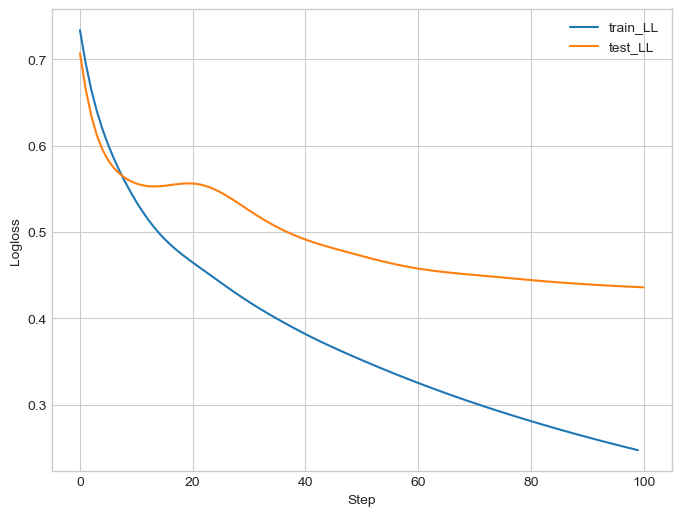

In [12]:
def plot_training_logs(model):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(model.log_train), label="train_LL")
    ax.plot(np.array(model.log_val), label="test_LL")
    ax.set(xlabel="Step", ylabel="Logloss")
    ax.legend()
    fig.show()


plot_training_logs(model_lightning)


Evaluate train and test data loaders

In [13]:
def predict_data_loader(model, data_loader):
    model.eval()

    y_est = []
    y_true = []
    with torch.no_grad():
        for img_batch, label_batch in data_loader:
            output = model(img_batch)
            probs = torch.nn.functional.sigmoid(output)

            y_est.append(probs)
            y_true.append(label_batch)

    y_est = torch.cat(y_est)
    y_true = torch.cat(y_true)

    return y_est, y_true


def tensor_to_sklearn_pred(pred):
    return np.stack([1 - pred, pred]).transpose()


y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["logistic_reg"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]


### Multi-layer perceptron

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 819 K 
2 | classifier | Linear            | 129   
-------------------------------------------------
819 K     Trainable params
0         Non-trainable params
819 K     Total params
3.279     Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, v_num=230, train_loss=0.00692, val_loss_step=0.513, val_acc_step=0.790, val_loss_epoch=0.513, val_acc_epoch=0.790]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 19.67it/s, v_num=230, train_loss=0.00692, val_loss_step=0.513, val_acc_step=0.790, val_loss_epoch=0.513, val_acc_epoch=0.790]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp


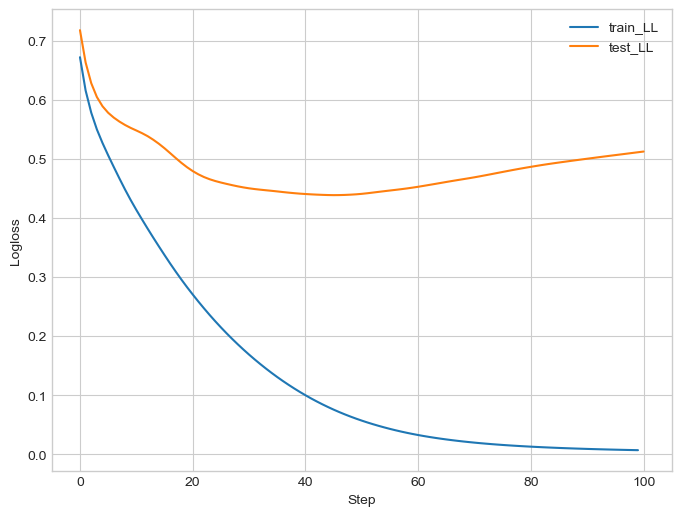

In [14]:
class MultiLayerPerceptron(BaseBinaryLightningModel):
    def __init__(
        self, num_classes=1, input_features=3072, learning_rate=0.01, output_bias=None
    ):
        super().__init__()

        self.features = nn.Sequential(
            nn.Linear(input_features, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()
        )
        self.classifier = nn.Linear(128, num_classes)

        if output_bias is not None:
            self.classifier.bias.data = output_bias

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.features(x)
        x = self.classifier(x)
        return x.flatten()


output_bias = torch.special.logit(labels_batch.type(torch.float).mean())
model_lightning = MultiLayerPerceptron(learning_rate=1e-4, output_bias=output_bias)
start_time = timeit.default_timer()
train_torch_model(model_lightning)
model_times["mlp"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["mlp"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]
evaluate_all_models(model_outputs)


### Convolution model

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 15.8 K
2 | classifier | Linear            | 17    
-------------------------------------------------
15.8 K    Trainable params
0         Non-trainable params
15.8 K    Total params
0.063     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 27.70it/s, v_num=231, train_loss=0.0015, val_loss_step=0.890, val_acc_step=0.790, val_loss_epoch=0.890, val_acc_epoch=0.790] 

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 23.27it/s, v_num=231, train_loss=0.0015, val_loss_step=0.890, val_acc_step=0.790, val_loss_epoch=0.890, val_acc_epoch=0.790]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn


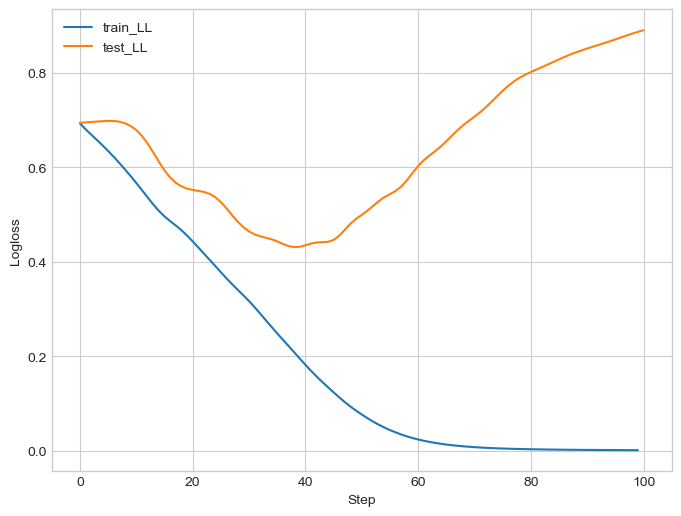

In [15]:
class SimpleCNN(BaseBinaryLightningModel):
    def __init__(self, num_classes=1, learning_rate=0.01):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=8, kernel_size=5, padding=2, stride=2
            ),  # batch, 8, 16, 16
            nn.ReLU(),
            nn.Conv2d(
                in_channels=8, out_channels=32, kernel_size=3, padding=2, stride=4
            ),  # batch, 32, 5, 5
            nn.ReLU(),
            nn.Flatten(),  # batch, 800
            nn.Linear(32 * 5 * 5, 16),
        )
        self.classifier = nn.Linear(16, num_classes)

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x.flatten()


model_lightning = SimpleCNN(learning_rate=1e-3)
start_time = timeit.default_timer()
train_torch_model(model_lightning, accelerator="gpu")
model_times["cnn"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["cnn"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


## Build imagenet classifiers
Imagenet is a commonly used dataset of about 1 million images and labels of about 1000 classes.


We're using an EfficientNet-B0 as it has similar performance to other models such as ResNet-50 and InceptionV3 but about 20% of the parameters.

We need to change the final layer from the original 1000 classes to a binary classification task.
The final layer takes in 1280 features and outputs log probs for 1000 classes.

We only want to retrain the final few layers so we freeze the early layers.

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 4.0 M 
2 | classifier | Linear            | 1.3 K 
-------------------------------------------------
1.3 K     Trainable params
4.0 M     Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  9.98it/s, v_num=232, train_loss=0.202, val_loss_step=0.641, val_acc_step=0.680, val_loss_epoch=0.641, val_acc_epoch=0.680]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  5.36it/s, v_num=232, train_loss=0.202, val_loss_step=0.641, val_acc_step=0.680, val_loss_epoch=0.641, val_acc_epoch=0.680]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier


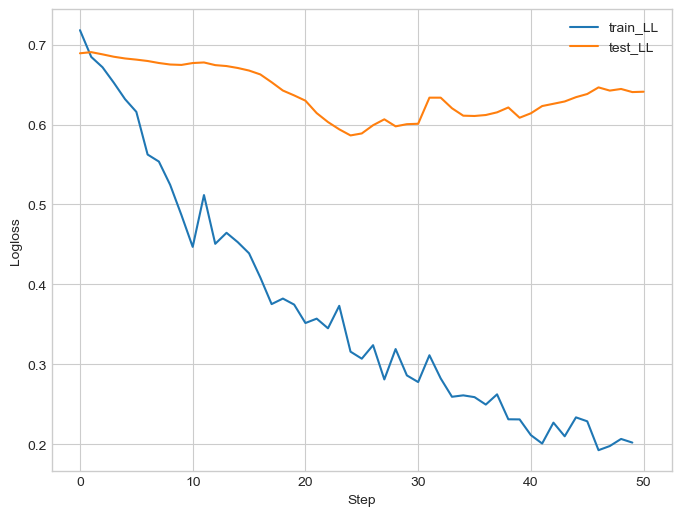

In [16]:
import torchvision.models as models


class EfficientNet(BaseBinaryLightningModel):
    def __init__(
        self,
        num_classes=1,
        learning_rate=0.01,
        freeze_all_layers=True,
        unfreeze_layers: int = None,
    ):
        super().__init__()

        # Load pre-trained EfficientNet model
        backbone = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )

        # recreate as pytorch module
        self.features = nn.Sequential(*list(backbone.children())[:-1])

        # Replace last fully-connected layer
        # get number of input features for new layer
        in_features = list(backbone.children())[-1][1].in_features
        # replace last fully-connected layer
        self.classifier = nn.Linear(in_features, num_classes)

        if freeze_all_layers:
            # Freeze all layers
            for param in self.features.parameters():
                param.requires_grad = False

            # Unfreeze last few layers
            if unfreeze_layers is not None:
                for param in self.features[0][-unfreeze_layers:].parameters():
                    param.requires_grad = True

        # Define optimizer
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x.flatten()


model_lightning = EfficientNet(
    learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=None
)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=50)
model_times["efficient_net_classifier"] = timeit.default_timer() - start_time


In [ ]:

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_classifier"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


### Train last features layer only


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 4.0 M 
2 | classifier | Linear            | 1.3 K 
-------------------------------------------------
413 K     Trainable params
3.6 M     Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The n

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  9.96it/s, v_num=233, train_loss=0.0279, val_loss_step=0.546, val_acc_step=0.770, val_loss_epoch=0.546, val_acc_epoch=0.770]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  5.31it/s, v_num=233, train_loss=0.0279, val_loss_step=0.546, val_acc_step=0.770, val_loss_epoch=0.546, val_acc_epoch=0.770]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier
5,0.024420,0.545856,1.00,0.74,efficient_net_1_layer


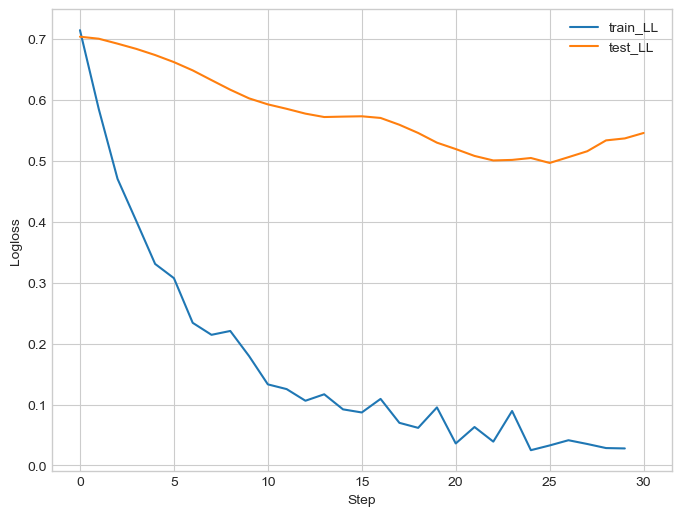

In [17]:
model_lightning = EfficientNet(
    learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=1
)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_1_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_1_layer"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


### Train last couple features layers


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 4.0 M 
2 | classifier | Linear            | 1.3 K 
-------------------------------------------------
1.1 M     Trainable params
2.9 M     Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The n

Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  9.41it/s, v_num=234, train_loss=0.015, val_loss_step=0.659, val_acc_step=0.800, val_loss_epoch=0.659, val_acc_epoch=0.800]  

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s, v_num=234, train_loss=0.015, val_loss_step=0.659, val_acc_step=0.800, val_loss_epoch=0.659, val_acc_epoch=0.800]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier
5,0.024420,0.545856,1.00,0.74,efficient_net_1_layer
6,0.002450,0.658949,1.00,0.79,efficient_net_2_layer


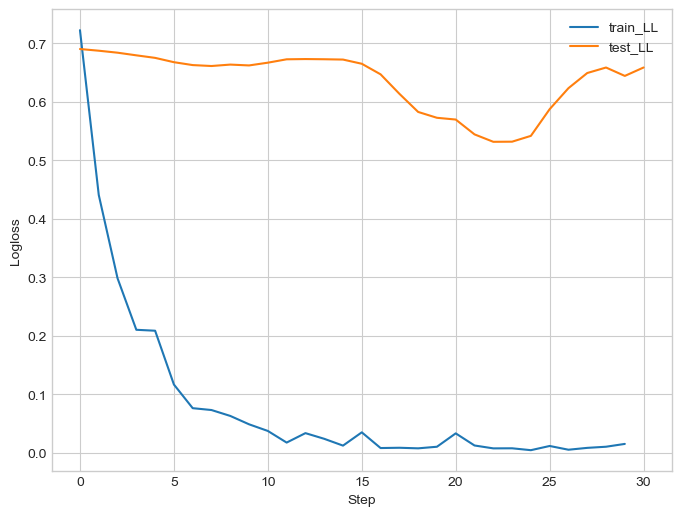

In [18]:
model_lightning = EfficientNet(
    learning_rate=1e-3, freeze_all_layers=True, unfreeze_layers=2
)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=30)
model_times["efficient_net_2_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_2_layer"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


### Train all feature layers
We would expect this to perform the best, but take the longest to train

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 4.0 M 
2 | classifier | Linear            | 1.3 K 
-------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The n

Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  4.82it/s, v_num=235, train_loss=0.000333, val_loss_step=0.481, val_acc_step=0.800, val_loss_epoch=0.481, val_acc_epoch=0.800]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s, v_num=235, train_loss=0.000333, val_loss_step=0.481, val_acc_step=0.800, val_loss_epoch=0.481, val_acc_epoch=0.800]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier
5,0.024420,0.545856,1.00,0.74,efficient_net_1_layer
6,0.002450,0.658949,1.00,0.79,efficient_net_2_layer
7,0.000203,0.480937,1.00,0.79,efficient_net_all_layer


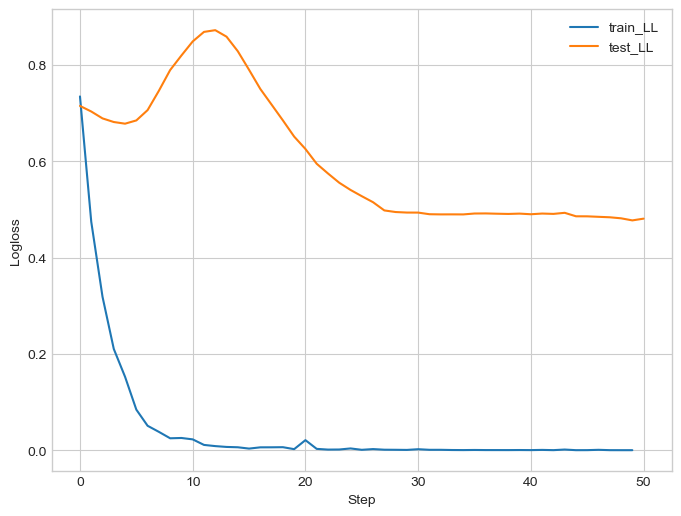

In [19]:
model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=False)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=50)
model_times["efficient_net_all_layer"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_all_layer"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type              | Params
-------------------------------------------------
0 | criterion  | BCEWithLogitsLoss | 0     
1 | features   | Sequential        | 4.0 M 
2 | classifier | Linear            | 1.3 K 
-------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.035    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/rich/Developer/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  4.79it/s, v_num=236, train_loss=0.000189, val_loss_step=0.597, val_acc_step=0.840, val_loss_epoch=0.597, val_acc_epoch=0.840]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, v_num=236, train_loss=0.000189, val_loss_step=0.597, val_acc_step=0.840, val_loss_epoch=0.597, val_acc_epoch=0.840]


/var/folders/ky/4qby95090jbbq38_mh94x72r0000gn/T/ipykernel_3799/1595659695.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier
5,0.024420,0.545856,1.00,0.74,efficient_net_1_layer
6,0.002450,0.658949,1.00,0.79,efficient_net_2_layer
7,0.000203,0.480937,1.00,0.79,efficient_net_all_layer
8,0.000117,0.596945,1.00,0.82,efficient_net_all_layer2


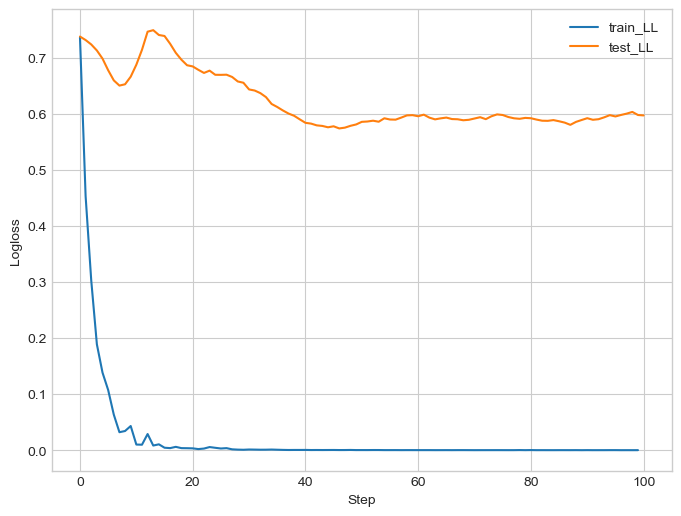

In [24]:
model_lightning = EfficientNet(learning_rate=1e-3, freeze_all_layers=False)

start_time = timeit.default_timer()
train_torch_model(model_lightning, epochs=100)
model_times["efficient_net_all_layer2"] = timeit.default_timer() - start_time

plot_training_logs(model_lightning)

y_train_est, y_true_train = predict_data_loader(model_lightning, train_loader)
y_test_est, y_true_test = predict_data_loader(model_lightning, test_loader)
model_outputs["efficient_net_all_layer2"] = [
    tensor_to_sklearn_pred(y_train_est),
    tensor_to_sklearn_pred(y_test_est),
]

evaluate_all_models(model_outputs)


# Todo

Case for early stopping

In [20]:
display(model_times)

evaluate_all_models(model_outputs)


{'sk_logistic_reg': 0.02015737514011562,
 'logistic_reg': 3.229210624936968,
 'mlp': 7.850016083102673,
 'cnn': 5.355671500088647,
 'efficient_net_classifier': 13.706477167084813,
 'efficient_net_1_layer': 6.60996308317408,
 'efficient_net_2_layer': 7.885567917022854,
 'efficient_net_all_layer': 27.3399489170406}

,log_loss_train,log_loss_test,accuracy_score_train,accuracy_score_test,name
0,0.349555,0.557117,0.83,0.75,sk_logistic_reg
1,0.245786,0.435934,0.95,0.79,logistic_reg
2,0.006728,0.512689,1.00,0.79,mlp
3,0.001456,0.889774,1.00,0.79,cnn
4,0.149582,0.641115,0.99,0.68,efficient_net_classifier
5,0.024420,0.545856,1.00,0.74,efficient_net_1_layer
6,0.002450,0.658949,1.00,0.79,efficient_net_2_layer
7,0.000203,0.480937,1.00,0.79,efficient_net_all_layer


What did it get wrong?

In [21]:
y_true_train != (y_est_train[:, 1] > y_est_train[:, 0])


NameError: name 'y_est_train' is not defined

In [ ]:
train_loader.dataset


Specific images

In [ ]:
from PIL import Image

image_paths = [
    "images/other/68364009651__BF66A2EF-0DC5-4AE7-B389-2694C17BED69.jpeg",
    "images/art/IMG_2759.JPG",
]
for image_path in image_paths:
    img = Image.open(image_path)
    img = transform(img)

    # Add a batch dimension to the image
    img = img.unsqueeze(0)

    # Pass the image through the model
    output = model_lightning(img)

    # Convert the output to probabilities
    probs = torch.nn.functional.softmax(output, dim=1)

    # Print the top 5 predicted classes and their probabilities
    print(probs)


tensor([[0.1394, 0.8606]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4723, 0.5277]], grad_fn=<SoftmaxBackward0>)


SHAP on images to find key elements?
Is the background key?

In [ ]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()
